## Training a convnet from scratch on a small dataset

### The relevance of deep learning for small-data problems

### Downloading the data

In [1]:
!unzip -qq '/fs/ess/PGS0333/BA_64061_KSU/data/dogs-vs-cats.zip'

In [2]:
!unzip -qq train.zip

**Copying images to training, validation, and test directories**

In [3]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2000)

### Building the model

**Instantiating a small convnet for dogs vs. cats classification**

In [4]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [5]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 128)       73856 

**Configuring the model for training**

In [6]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

### Data preprocessing

**Using `image_dataset_from_directory` to read images**

In [7]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [8]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [9]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [10]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [11]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


**Displaying the shapes of the data and labels yielded by the `Dataset`**

In [12]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


**Fitting the model using a `Dataset`**

In [13]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 5s 40ms/step - loss: 0.7304 - accuracy: 0.5260 - val_loss: 0.6907 - val_accuracy: 0.5320
Epoch 2/30
63/63 [==============================] - 2s 30ms/step - loss: 0.6960 - accuracy: 0.5375 - val_loss: 0.6820 - val_accuracy: 0.5130
Epoch 3/30
63/63 [==============================] - 2s 29ms/step - loss: 0.6786 - accuracy: 0.5990 - val_loss: 0.6654 - val_accuracy: 0.5630
Epoch 4/30
63/63 [==============================] - 2s 29ms/step - loss: 0.6267 - accuracy: 0.6745 - val_loss: 0.6434 - val_accuracy: 0.6100
Epoch 5/30
63/63 [==============================] - 2s 29ms/step - loss: 0.5868 - accuracy: 0.6835 - val_loss: 0.6331 - val_accuracy: 0.6580
Epoch 6/30
63/63 [==============================] - 2s 29ms/step - loss: 0.5523 - accuracy: 0.7260 - val_loss: 0.5735 - val_accuracy: 0.7090
Epoch 7/30
63/63 [==============================] - 2s 29ms/step - loss: 0.5220 - accuracy: 0.7515 - val_loss: 0.5823 - val_accuracy: 0.6890
Epoch 8/30
63

**Displaying curves of loss and accuracy during training**

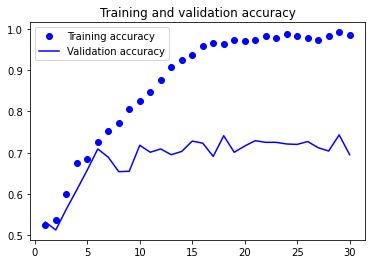

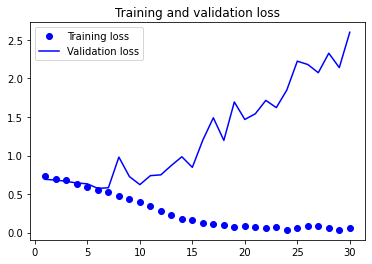

In [14]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [15]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 15ms/step - loss: 0.6177 - accuracy: 0.6860
Test accuracy: 0.686


### Using data augmentation

**Define a data augmentation stage to add to an image model**

In [16]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

**Displaying some randomly augmented training images**

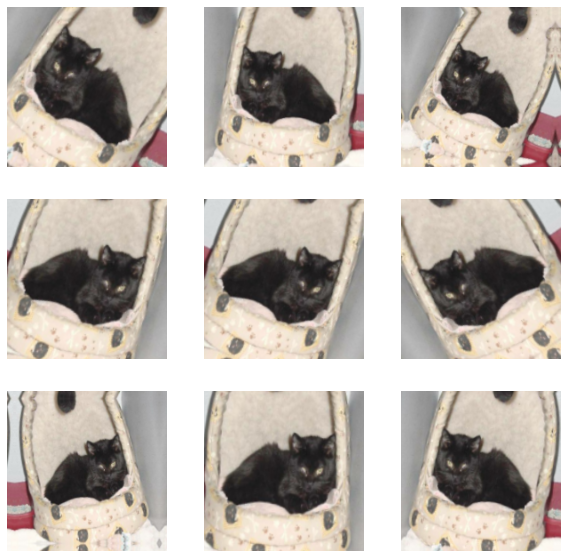

In [17]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Defining a new convnet that includes image augmentation and dropout**

In [18]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**Training the regularized convnet**

In [19]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 3s 33ms/step - loss: 0.7811 - accuracy: 0.5150 - val_loss: 0.6957 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 2s 30ms/step - loss: 0.7162 - accuracy: 0.5330 - val_loss: 0.7097 - val_accuracy: 0.5030
Epoch 3/100
63/63 [==============================] - 2s 30ms/step - loss: 0.7015 - accuracy: 0.5365 - val_loss: 0.6667 - val_accuracy: 0.5590
Epoch 4/100
63/63 [==============================] - 2s 30ms/step - loss: 0.6835 - accuracy: 0.5770 - val_loss: 3.0418 - val_accuracy: 0.5000
Epoch 5/100
63/63 [==============================] - 2s 32ms/step - loss: 0.6830 - accuracy: 0.6270 - val_loss: 0.7004 - val_accuracy: 0.5750
Epoch 6/100
63/63 [==============================] - 2s 31ms/step - loss: 0.6421 - accuracy: 0.6260 - val_loss: 0.6255 - val_accuracy: 0.6830
Epoch 7/100
63/63 [==============================] - 2s 32ms/step - loss: 0.6600 - accuracy: 0.6535 - val_loss: 0.6311 - val_accuracy: 0.6290
Epoch 

**Evaluating the model on the test set**

In [20]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 15ms/step - loss: 0.5535 - accuracy: 0.8400
Test accuracy: 0.840


## Leveraging a pretrained model

### Feature extraction with a pretrained model

**Instantiating the VGG16 convolutional base**

In [21]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58900480/58889256 [==============================] - 1s 0us/step


In [22]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 180, 180, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 180, 180, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 90, 90, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 90, 90, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 90, 90, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 45, 45, 128)       0     

#### Fast feature extraction without data augmentation

**Extracting the VGG16 features and corresponding labels**

In [23]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

In [24]:
train_features.shape

(2000, 5, 5, 512)

**Defining and training the densely connected classifier**

In [25]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 1s 6ms/step - loss: 13.9988 - accuracy: 0.9290 - val_loss: 4.1059 - val_accuracy: 0.9660
Epoch 2/20
63/63 [==============================] - 0s 4ms/step - loss: 3.8128 - accuracy: 0.9745 - val_loss: 3.1748 - val_accuracy: 0.9790
Epoch 3/20
63/63 [==============================] - 0s 3ms/step - loss: 2.4587 - accuracy: 0.9840 - val_loss: 8.4137 - val_accuracy: 0.9600
Epoch 4/20
63/63 [==============================] - 0s 3ms/step - loss: 1.6528 - accuracy: 0.9905 - val_loss: 6.7543 - val_accuracy: 0.9660
Epoch 5/20
63/63 [==============================] - 0s 3ms/step - loss: 1.7387 - accuracy: 0.9885 - val_loss: 17.7083 - val_accuracy: 0.9330
Epoch 6/20
63/63 [==============================] - 0s 3ms/step - loss: 1.0555 - accuracy: 0.9930 - val_loss: 5.5018 - val_accuracy: 0.9700
Epoch 7/20
63/63 [==============================] - 0s 3ms/step - loss: 0.4787 - accuracy: 0.9945 - val_loss: 5.1206 - val_accuracy: 0.9780
Epoch 8/20
63/63 [

**Plotting the results**

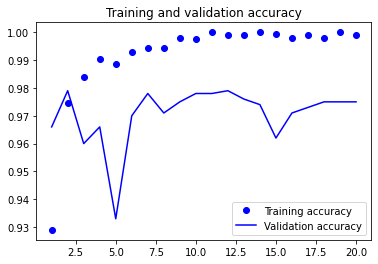

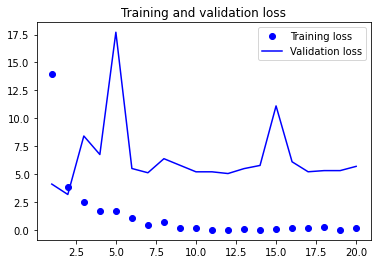

In [26]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#### Feature extraction together with data augmentation

**Instantiating and freezing the VGG16 convolutional base**

In [27]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

**Printing the list of trainable weights before and after freezing**

In [28]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [29]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


**Adding a data augmentation stage and a classifier to the convolutional base**

In [30]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [31]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 5s 57ms/step - loss: 15.8862 - accuracy: 0.8920 - val_loss: 2.3043 - val_accuracy: 0.9790
Epoch 2/50
63/63 [==============================] - 3s 52ms/step - loss: 6.9969 - accuracy: 0.9470 - val_loss: 1.9802 - val_accuracy: 0.9820
Epoch 3/50
63/63 [==============================] - 3s 52ms/step - loss: 5.7805 - accuracy: 0.9585 - val_loss: 3.0141 - val_accuracy: 0.9790
Epoch 4/50
63/63 [==============================] - 3s 52ms/step - loss: 4.9604 - accuracy: 0.9580 - val_loss: 2.6882 - val_accuracy: 0.9790
Epoch 5/50
63/63 [==============================] - 3s 53ms/step - loss: 3.9482 - accuracy: 0.9645 - val_loss: 3.0320 - val_accuracy: 0.9810
Epoch 6/50
63/63 [==============================] - 3s 52ms/step - loss: 3.4068 - accuracy: 0.9670 - val_loss: 6.7638 - val_accuracy: 0.9610
Epoch 7/50
63/63 [==============================] - 3s 53ms/step - loss: 2.8548 - accuracy: 0.9710 - val_loss: 4.8986 - val_accuracy: 0.9690
Epoch 8/50
6

**Evaluating the model on the test set**

In [32]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 33ms/step - loss: 2.0690 - accuracy: 0.9760
Test accuracy: 0.976


### Fine-tuning a pretrained model

In [33]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

**Freezing all layers until the fourth from the last**

In [34]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

**Fine-tuning the model**

In [35]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 5s 60ms/step - loss: 0.4628 - accuracy: 0.9890 - val_loss: 1.9689 - val_accuracy: 0.9800
Epoch 2/30
63/63 [==============================] - 4s 56ms/step - loss: 0.5023 - accuracy: 0.9880 - val_loss: 1.7843 - val_accuracy: 0.9750
Epoch 3/30
63/63 [==============================] - 4s 56ms/step - loss: 0.2672 - accuracy: 0.9915 - val_loss: 1.6897 - val_accuracy: 0.9780
Epoch 4/30
63/63 [==============================] - 4s 60ms/step - loss: 0.1813 - accuracy: 0.9945 - val_loss: 1.5242 - val_accuracy: 0.9820
Epoch 5/30
63/63 [==============================] - 4s 56ms/step - loss: 0.3211 - accuracy: 0.9910 - val_loss: 1.8899 - val_accuracy: 0.9790
Epoch 6/30
63/63 [==============================] - 4s 57ms/step - loss: 0.3550 - accuracy: 0.9890 - val_loss: 1.4699 - val_accuracy: 0.9810
Epoch 7/30
63/63 [==============================] - 4s 56ms/step - loss: 0.1614 - accuracy: 0.9950 - val_loss: 1.7046 - val_accuracy: 0.9820
Epoch 8/30
63

In [36]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 32ms/step - loss: 2.0491 - accuracy: 0.9760
Test accuracy: 0.976


## Summary